In [7]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
import numpy as np, pandas as pd
from fastai.imports import *
import seaborn as sns
import graphviz

In [8]:
np.set_printoptions(linewidth=130)

# Artigo 6 - Random Forests

## 1. Introdução

O tema da aula 6 é *Random Forests*, e nesse artigo vamos aprender o que são, como criá-las, e como interpretá-las.

## 2. Objetivo

Entender os passos necessários para criar uma *random forest* e colocá-los em prática. 

## 3. Inspiração



Usei um dataset que contém a idade e salário estimado de pessoas que compraram (ou não) um produto após ver um anúncio em redes sociais, feito por Shubham Singh no [Kaggle](https://www.kaggle.com/datasets/shub99/social-network-ads).

<img src="assets/dataset.png" alt="" width="700" /><br>

## 4. Execução

### 4.1 Processamento dos dados

Vamos começar criando um dataframe com nossos dados:

In [9]:
df = pd.read_csv('Social_Network_Ads.csv')
df

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0
...,...,...,...
395,46,41000,1
396,51,23000,1
397,50,20000,1
398,36,33000,0


Para este exercício, queremos transformar a coluna idade (*Age*) em um variável categórica, então vamos dividir as entradas no meio. Para isso precisamos dos valores máximo e mínimo dessa coluna:

In [10]:
df.loc[df['Age'].idxmax()]

Age                    60
EstimatedSalary    108000
Purchased               1
Name: 215, dtype: int64

In [11]:
df.loc[df['Age'].idxmin()]

Age                   18
EstimatedSalary    82000
Purchased              0
Name: 14, dtype: int64

Tendo os valores máximo e mínimo, podemos identificar o meio, que no nosso caso é 38. Vamos dividir as entradas entre maiores e menores de 38 anos:

In [12]:
df['Aged_18_to_38'] = df['Age'].between(18,38)
df['Aged_18_to_38'] = df['Aged_18_to_38'].astype(int)
df

,Age,EstimatedSalary,Purchased,Aged_18_to_38
0,19,19000,0,1
1,35,20000,0,1
2,26,43000,0,1
3,27,57000,0,1
4,19,76000,0,1
...,...,...,...,...
395,46,41000,1,0
396,51,23000,1,0
397,50,20000,1,0
398,36,33000,0,1


O método `between(min, max)` retorna um *boolean* para cada item do dataframe, **True** caso o valor esteja entre *min* e *max*, incluso, e **False** caso contrário.

Passamos os valores para *int* através do método `.astype(int)`.

In [13]:
df.describe()

,Age,EstimatedSalary,Purchased,Aged_18_to_38
count,400.000000,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500,0.557500
std,10.482877,34096.960282,0.479864,0.497305
min,18.000000,15000.000000,0.000000,0.000000
25%,29.750000,43000.000000,0.000000,0.000000
50%,37.000000,70000.000000,0.000000,1.000000
75%,46.000000,88000.000000,1.000000,1.000000
max,60.000000,150000.000000,1.000000,1.000000


Através do `describe()` podemos ver que o salário varia entre 15,000 e 150,000. Podemos usar um histograma para visualizar sua distribuição:

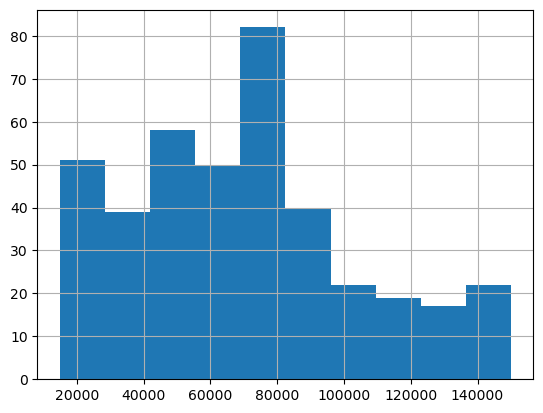

In [14]:
df['EstimatedSalary'].hist();

Vamos passar essa coluna por uma função logarítmica para reduzir a discrepância.

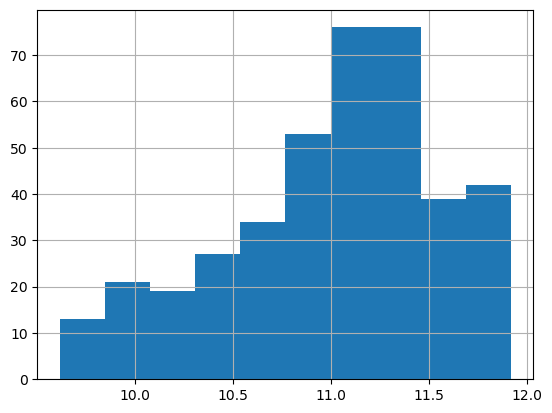

In [15]:
df['LogSalary'] = np.log(df['EstimatedSalary']+1)
df['LogSalary'].hist();

A seguir, removemos as colunas que não nos interessam mais.

In [16]:
df.drop(['Age', 'EstimatedSalary'], axis=1 ,inplace=True)
df.head()

,Purchased,Aged_18_to_38,LogSalary
0,0,1,9.852247
1,0,1,9.903538
2,0,1,10.668979
3,0,1,10.950824
4,0,1,11.238502


Seguindo em frente, vamos separar nossas variáveis em três tipos:

<img src="assets/variaveis.jpg" alt="" width="500" /><br>

Vamos listar as variáveis contínuas, categoricas, e dependentes:

In [6]:
cat = ['Aged_18_to_38',]
cont = ['LogSalary',]
dep = 'Purchased'

### 4.2 *Binary splits*

Antes de criar uma floresta aleatória, precisamos criar uma árvore de decisão para compô-la, e para criar a árvore precisamos de uma divisão binária.

Uma divisão binária separa todas as linhas em dois grupos, com base se o valor daquela linha está acima ou abaixo de um limiar. Por exemplo, aqui vamos separar os dados entre aqueles de 18-38 anos e aqueles com 39 ou mais, e como na nossa coluna de idade as pessoas de 18-38 anos tem o valor `1` e as outras `0`, podemos definir o limiar como `0.5`, assim dividindo os dois.

Vamos construir um gráfico da biblioteca `Seaborn` para visualizar melhor nossa divisão:


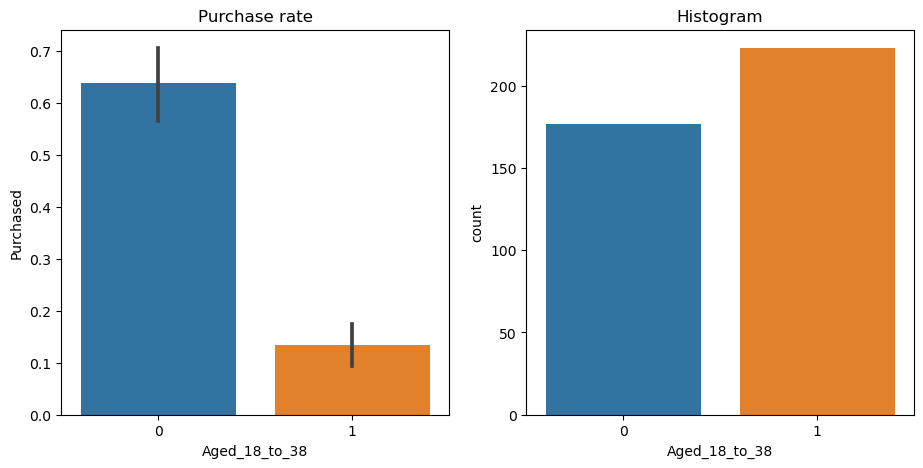

In [12]:
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Aged_18_to_38", ax=axs[0]).set(title="Purchase rate")
sns.countplot(data=df, x="Aged_18_to_38", ax=axs[1]).set(title="Histogram");

Podemos ver que aqueles com 38 anos ou menos, demonstrados em laranja, tem uma taxa de compra muito baixa (<15%) quando comparado aos maiores de 38 anos (>60%), apesar da quantidade de ambos os grupos ser comparável, como visto no histograma.

Podemos criar um simples "modelo" que prediz que todos os *>38* compraram o produto, e todos os *<=38* não. Para isso devemos separar nossos dados entre treino e validação primeiro:

In [18]:
trn_df,val_df = train_test_split(df, test_size=0.25)

Vamos então criar as variáveis independentes (chamadas de **x**), e a dependente (**y**):

In [19]:
def xs_y(df):
    xs = df[cat+cont].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

Aqui estão as inferências para o nosso modelo, onde os *>38* estão marcados como 0:

In [15]:
preds = val_xs.Aged_18_to_38==0

Podemos ver o quão precisas são as inferências através do erro médio absoluto:

In [16]:
mean_absolute_error(val_y, preds)

0.28

A seguir vamos dar uma olhada no `LogSalary` através de alguns gráficos:

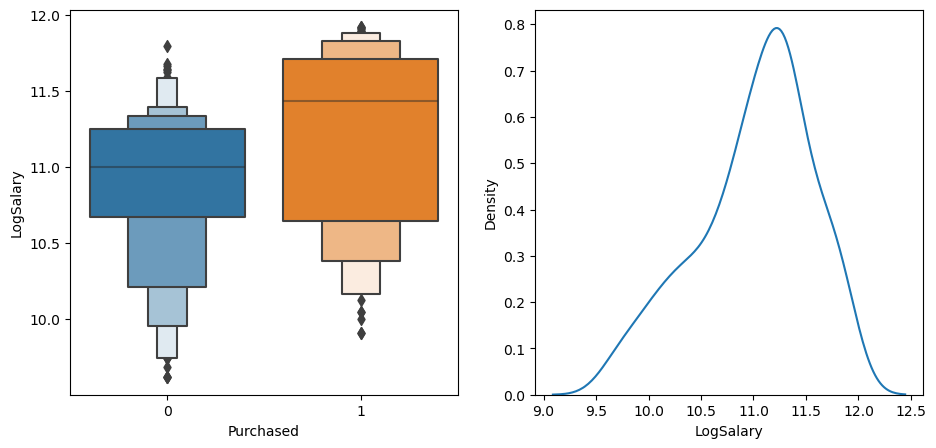

In [17]:
df_salary = trn_df[trn_df.LogSalary>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_salary, x=dep, y="LogSalary", ax=axs[0])
sns.kdeplot(data=df_salary, x="LogSalary", ax=axs[1]);

Pelo gráfico da esquerda podemos notar que a média do `LogSalary` das pessoas que compraram o produto (demonstrado em laranja) é por volta de 11.5, enquanto a média daqueles que não compraram é 11.0. Já o gráfico da direita nos mostra que a maior parte dos participantes tem o `LogSalary` por volta de 11.2.

Vamos criar um modelo baseado nessas observações:

In [18]:
preds = val_xs.LogSalary>11.2
mean_absolute_error(val_y, preds)

0.36

Como podemos ver, o erro aumentou bastante quando comparado ao modelo que infere baseado na idade.

Vamos criar uma função `score` para medir o quão bom cada modelo é. Essa função vai calcular o grau de impureza, ou seja, a semelhança entre os elementos de cada grupo.

Podemos medir a similaridade através do desvio padrão da variável dependente. Se for maior, as linhas são mais diferentes entre si. Então vamos multiplicar esse número pela quantidade de linhas, já que um grupo maior tem mais impacto do que um menor.

In [19]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

Podemos calcular o `score` de uma divisão binária somandos os `scores` do lado esquerdo (lhs) e direito (rhs).

In [20]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

Vamos ver o grau de impureza para os grupos gerados por idade:

In [21]:
score(trn_xs["Aged_18_to_38"], trn_y, 0.5)

0.3923495968261936

E por salário:

In [22]:
score(trn_xs["LogSalary"], trn_y, 11.2)

0.4523081909897375

Queremos agora achar o melhor limiar para cada coluna, ou seja, o valor que melhor divide os dados entre aqueles que compraram e não compraram o produto.

Para isso podemos criar uma função que pega todos os valores únicos de cada coluna e calcula os `scores` em busca do menor.

In [23]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

Vamos testar a função nas nossas colunas:

In [24]:
cols = cat+cont
{o:min_col(trn_df, o) for o in cols}

{'Aged_18_to_38': (0, 0.3923495968261936),
 'LogSalary': (11.39640288460621, 0.39668954050590766)}

De acordo com o resultado, Aged_18_to_38 <= 0 é a melhor divisão que podemos fazer, com impureza de **0.392**, enquanto LogSalary <= 11.39 tem uma impureza de **0.396**. 

### 4.3 Decision Tree

Para melhorar nosso modelo rudimentar, vamos pegar nossos dois grupos, `<=38` e `>38` e criar outra divisão binária para eles, ou seja, achar o melhor limiar de salário para cada grupo.

Para isso removemos a coluna de idade da lista de divisões, e criamos os dois grupos, chamados aqui de `young` para os <=38 e `old` para os >38.

In [25]:
cols.remove("Aged_18_to_38")
is_young = trn_df.Aged_18_to_38==1
young,old = trn_df[is_young],trn_df[~is_young]

In [26]:
{o:min_col(young, o) for o in cols}

{'LogSalary': (11.407576060361786, 0.17988165972931766)}

In [27]:
{o:min_col(old, o) for o in cols}

{'LogSalary': (11.326607934898927, 0.39943177387231577)}

De acordo com os resultados, os `<=38` como o limiar 11.4 tem um grau de impureza de 0.17 apenas, enquanto para os >38 com limiar 11.3 o grau de impureza é quase 0.4. Isso significa que o salário não é tão relevante na decisão de comprar ou não um produto para esse grupo.

Dessa forma, criamos uma árvore de decisão, onde o modelo checa se a idade é menor ou maior do que 38, e depois aplica os limiares definidos acima. Esse processo poderia ser repetido, criando novos limiares para os 4 grupos gerados e assim por diante.

O módulo `sklearn` nos provê uma função para fazer exatemente isso:

In [23]:
m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

Vamos usar a biblioteca `graphviz` para visualizar nossa árvore:

In [22]:
def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

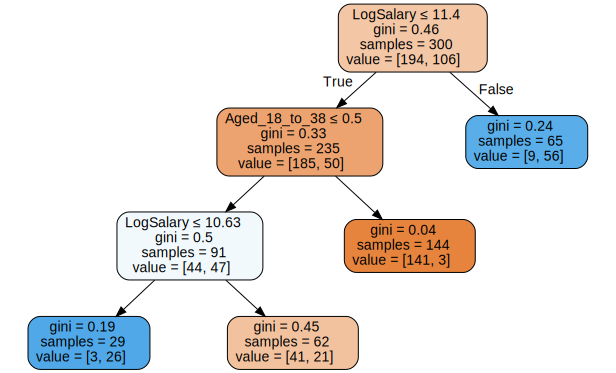

In [30]:
draw_tree(m, trn_xs, size=10)

No gráfico podemos ver em laranja os grupos que compraram mais, em azul os que compraram menos, e em branco os divididos igualmente.

Também temos o `gini` que similar ao grau de impureza, nos diz a similaridade dos dados em um grupo. Um gini 0 seria para todos os elementos iguais, e 1 seria para todos os elementos diferentes. A seguir sua definição:

In [31]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

Exemplo do gini em ação nas nossas colunas:

In [32]:
gini(df.Aged_18_to_38==1), gini(df.Aged_18_to_38==0)

(0.2328621126505661, 0.4616808707587219)

Vamos ver como o novo modelo se compara com o primeiro:

In [33]:
mean_absolute_error(val_y, m.predict(val_xs))

0.13

Consideravelmente melhor, mas vamos tentar criar uma árvore maior:

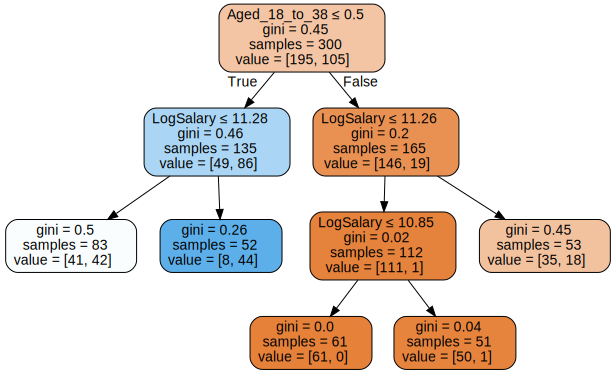

In [24]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

In [35]:
mean_absolute_error(val_y, m.predict(val_xs))

0.2

Dessa vez o erro aumentou, isso se dá porque cada folha acaba tendo poucos dados. Uma árvore profunda demais é propensa a overfit, por isso deve-se evitar criar árvores grandes com um dataset reduzido.

### 4.4 Random Forest

Ao invés de criar uma árvore muito profunda, podemos criar várias árvores profundas e tirar a média de suas inferências. Esse método é conhecido como `bagging`.

A ideia é que cada inferência não seja relacionada com as outras, dessa forma, quando tirarmos a média, o resultado vai ser igual ao valor verdadeiro. Isso se dá porque a média entre vários erros não relacionados é zero.

Uma forma de criar moodelos não relacionados é treinar cada um em subgrupos diferentes dos dados:

In [41]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = np.random.choice(n, int(n*prop))
    x = trn_xs.iloc[idxs]
    y = trn_y.iloc[idxs]
    return DecisionTreeClassifier(min_samples_leaf=5).fit(x, y)

Agora criamos vários modelos:

In [42]:
trees = [get_tree() for t in range(100)]

E nossa inferência vai ser a média entre todas as inferências:

In [43]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.1565

O `sklearn` tem uma função para isso, a única diferença sendo que ela seleciona um subgrupo de colunas aleatório para cada divisão.

In [45]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.14

Podemos ver a seguir a importância de cada coluna para a inferência:

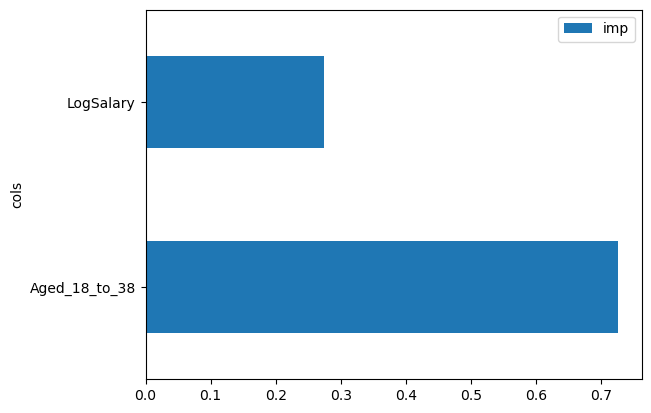

In [25]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

### 4.5 Hugging Face

Para exportar o modelo para o Hugging Face, precisamos fazer alguns ajustes.

Primeiramente vamos ver o nosso `val_xs` que é usado nas predições:

In [51]:
val_xs

,Aged_18_to_38,LogSalary
136,1,11.314487
59,1,11.669938
280,0,11.385103
371,0,11.326608
32,1,9.680406
...,...,...
368,1,11.170449
20,0,9.998843
208,0,11.863589
328,1,11.678448


Vamos criar um DataFrame de exemplo com os dados que precisamos para uma inferência, e fazer as alterações necessárias nele:

In [89]:
info = {
    'Age': [60,22,39],
    'Salary': [100000,60000,90000]
}

def prep_data(dataframe):
    dataframe['Aged_18_to_38'] = dataframe['Age'].between(18,38)
    dataframe['Aged_18_to_38'] = dataframe['Aged_18_to_38'].astype(int)
    dataframe['LogSalary'] = np.log(dataframe['Salary']+1)
    dataframe.drop(['Age', 'Salary'], axis=1 ,inplace=True)

test = pd.DataFrame(info)


In [86]:
test.head()

,Age,Salary
0,60,100000
1,22,60000
2,39,60000


In [90]:
prep_data(test)
test.head()

,Aged_18_to_38,LogSalary
0,0,11.512935
1,1,11.002117
2,0,11.407576


Vamos então realizar a inferência para nossos valores de exemplo:

In [91]:
print(rf.predict(test))

[1 0 1]


Tudo certo. Agora é só exportar o arquivo `.pickle` com nosso modelo, passar o código acima para o `app.py`.

In [46]:
pickle.dump(rf, open('classifier.pickle', 'wb'))

Link para a página do [HuggingFace](https://huggingface.co/spaces/vnsrz/artigo6).

<img src="assets/hgface.png" alt="" width="800" /><br>

### App.py

```python
import numpy as np, pandas as pd
import gradio as gr
import pickle

def prep_data(dataframe):
    dataframe['Aged_18_to_38'] = dataframe['Age'].between(18,38)
    dataframe['Aged_18_to_38'] = dataframe['Aged_18_to_38'].astype(int)
    dataframe['LogSalary'] = np.log(dataframe['Salary']+1)
    dataframe.drop(['Age', 'Salary'], axis=1 ,inplace=True)

def classify(age, salary):
    info = {
        'Age': [age,],
        'Salary': [salary,]
    }
    df = pd.DataFrame(info)
    prep_data(df)
    pred = learn.predict(df)
    if pred[0]:
        return 'Purchased'
    else:
        return 'Didn\'t purchase'

with open('classifier.pickle', 'rb') as file:
    learn = pickle.load(file)

examples = [[22, 60_000],[60, 100_000],[39, 90_000]]
description ='Random forest that predicts if a user has bought a product or not by viewing the social ads of the product, given his age and estimated salary.'

intf = gr.Interface(fn=classify, inputs=['number', 'number'], outputs=['text'], description=description, examples=examples)
intf.launch(inline=False)

```

## 5. Conclusão

Achei muito interessante o conceito de Random Forests, que parte de um princípio simples, realizar uma inferência com base em 1 informação, e se torna um modelo viável sem muita complexidade de entendimento.

As bibliotecas usadas para gerar gráficos foram muito importantes para dar uma compreensão maior dos dados que estão sendo utilizados. 